# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [11]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from datetime import date, time
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

#DATA_FOLDER = "/Users/karunya/Documents/EPFL/ADA/ADA2017-Tutorials/Intro_to_Pandas/Data"
# DATA_FOLDER = "/Users/Gaurav/Desktop/ADA/ADA2017-Tutorials/02 - Intro to Pandas/Data"


DATA_FOLDER = "/Users/laurieprelot/Documents/GitHub/ADA2017-Tutorials/02 - Intro to Pandas/Data"

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [12]:
#Create 3 Dataframes (one for each country)
filenames = glob.glob(DATA_FOLDER +"/ebola/guinea_data/"+"*.csv")
get_dfs = (pd.read_csv(f) for f in filenames)
guinea = pd.concat(get_dfs, ignore_index=True)
guinea['Country']='Guinea'

filenames = glob.glob(DATA_FOLDER +"/ebola/liberia_data/"+"*.csv")
get_dfs = (pd.read_csv(f) for f in filenames)
liberia = pd.concat(get_dfs, ignore_index=True)
liberia['Country'] ='Liberia'

filenames = glob.glob(DATA_FOLDER +"/ebola/sl_data/"+"*.csv")
get_dfs = (pd.read_csv(f) for f in filenames)
sl = pd.concat(get_dfs, ignore_index=True)
sl['Country'] ='Sierra Leone'

In [13]:
#Homogenize Column Names
guinea.rename(columns={'Description': 'Variable', 'Totals':'National'}, inplace=True)
sl.rename(columns={'date': 'Date', 'variable':'Variable'}, inplace=True)

In [14]:
# Merge Tables
liberia_table = liberia[['Country','Date','Variable','National']]
guinea_table = guinea[['Country','Date','Variable','National']]
sl_table = sl[['Country','Date','Variable','National']]
# Concatenate Tables on Rows
merged_table = pd.concat([liberia_table, guinea_table, sl_table], axis=0)

In [15]:
# Reformat Dates
merged_table['Date'] = merged_table['Date'].apply(parse)

### Method
The method choosen relies on creating two additional columns that will contain the number of real death and new cases 

In [16]:
# Set country and date as indexes
merged_table = merged_table.set_index(['Country','Date'])

In [17]:
'''Exploratory Search for Death'''
# pattern1 = 'death'
# '''
# HWC: stands for Human wild life conflict,
# cum: prbably for cumulative,
# CTE, ETC: centre traitement Ebola
# '''
# Get all deaths modalities in a data frame
# pd.Series(pd.unique(merged_table.Variable[merged_table.Variable.str.contains(pattern1)]))

# # Type of Deaths
# (merged_table[merged_table.Variable.str.contains(pattern1)])

# # Type of death in each country 
# country = 'Sierra Leone'
# merged_table.loc[country][merged_table.loc[country].Variable.str.contains(pattern1)]

'Exploratory Search for Death'

### Search Results for New Deaths
* Liberia = Newly reported deaths, Newly Reported deaths in HCW
* Guinea = New deaths registered today, New deaths registered, New deaths registered among health workers
* Sierra Leone = death_suspected, death_probable, death_confirmed

### Calculations for Total New Deaths
* Liberia = SUM(Newly reported deaths, Newly Reported deaths in HCW)
* Guinea: SUM(New deaths registered, New deaths registered,New deaths registered among health workers)
* Sierra Leone: SUM(death_suspected[j+1] - death_suspected[j], death_probable[j+1] - death_probable[j], death_confirmed[j+1] - death_confirmed[j])

In [18]:
'''Choice of real deaths, identify death to take into accout'''
deathperday = ['Newly Reported deaths in HCW', 'Newly reported deaths', 'New deaths registered today', 'New deaths registered', 'New deaths registered among health workers', 'death_suspected', 'death_probable', 'death_confirmed']

In [19]:
'''Exploratory Search for New Cases'''
# pattern2 ='ew'

# Create a series with cases
# cases = pd.Series(pd.unique(merged_table.Variable[merged_table.Variable.str.contains(pattern2)]))
# Create a serie with cases that are not deaths nor non cases
# cases[cases.str.contains('death|noncase')==False] 

# Type of of cases in one country 
# country = 'Sierra Leone'
# merged_table.loc[country][merged_table.loc[country].Variable.str.contains(pattern2)]

'Exploratory Search for New Cases'

### Calculations for New Cases
* Liberia = SUM(New Case/s (Suspected), New Case/s (Probable), New case/s (confirmed))
* Guinea = SUM(New cases of confirmed among health workers, Total new cases registered so far)
* Sierra Leone = SUM(new_confirmed, new_probable, new_suspected)

In [20]:
'''Choice of new cases, identify cases to take into accout'''
caseperday = ['New Case/s (Suspected)' ,'New Case/s (Probable)', 'New case/s (confirmed)', 'Total new cases registered so far', 'New cases of confirmed among health workers', 'new_confirmed', 'new_probable', 'new_suspected']

### Correct Cumalitive Values for Deaths in Sierra Leone

In [21]:
correction = ['death_suspected','death_probable','death_confirmed']
cum_table = merged_table[merged_table.Variable.isin(correction)]
dates = cum_table.index.tolist()
cum_table.National.fillna(0, inplace=True)

prev_index = cum_table.index[0]
prev_sus_cum = int(cum_table.loc[prev_index].National[cum_table.loc[prev_index].Variable.isin([correction[0]])].values[0])
prev_prob_cum = int(cum_table.loc[prev_index].National[cum_table.loc[prev_index].Variable.isin([correction[1]])].values[0])
prev_confirm_cum = int(cum_table.loc[prev_index].National[cum_table.loc[prev_index].Variable.isin([correction[2]])].values[0])

date = 3
sus_total = 0
prob_total = 0
confirm_total = 0

days_sus = 0
days_prob = 0
days_confirm = 0

while date < len(dates):
    curr_index = cum_table.index[date]
    curr_sus_cum = int(cum_table.loc[curr_index].National[cum_table.loc[curr_index].Variable.isin([correction[0]])].values[0])
    curr_prob_cum = int(cum_table.loc[curr_index].National[cum_table.loc[curr_index].Variable.isin([correction[1]])].values[0])
    curr_confirm_cum = int(cum_table.loc[curr_index].National[cum_table.loc[curr_index].Variable.isin([correction[2]])].values[0])
    
    if(curr_sus_cum != 0):
        curr_sus = curr_sus_cum - prev_sus_cum
        sus_total += curr_sus
        prev_sus_cum = curr_sus_cum
        days_sus += 1
    
    if(curr_prob_cum != 0):
        curr_prob = curr_prob_cum - prev_prob_cum
        prob_total += curr_prob
        prev_prob_cum = curr_prob_cum
        days_prob += 1
        
    if(curr_confirm_cum != 0):
        curr_confirm = curr_confirm_cum - prev_confirm_cum
        confirm_total += curr_confirm
        prev_confirm_cum = curr_confirm_cum
        days_confirm += 1
    
    date += 3

print('Suspected Deaths avg per Day: ' + str(sus_total/float(days_sus)))
print('Probable Deaths avg per Day: ' + str(prob_total/float(days_prob)))
print('Confirmed Deaths avg per Day: ' + str(confirm_total/float(days_confirm)))

Suspected Deaths avg per Day: 1.6105263157894736
Probable Deaths avg per Day: 1.831578947368421
Confirmed Deaths avg per Day: 15.2


In [22]:
# Create a columns with the deaths and one with the new cases and remove Nas
merged_table['deaths_per_day'] = np.where(merged_table.Variable.isin(deathperday), merged_table['National'], 0)
merged_table['cases_per_day'] = np.where(merged_table.Variable.isin(caseperday), merged_table['National'], 0)
merged_table.deaths_per_day.fillna(0, inplace=True)
merged_table.cases_per_day.fillna(0, inplace=True)
merged_table['deaths_per_day'] = pd.to_numeric(merged_table.deaths_per_day)
merged_table['cases_per_day'] = pd.to_numeric(merged_table.cases_per_day)

                                     
liberia_deaths = merged_table.loc['Liberia'][merged_table.loc['Liberia'].Variable.isin(deathperday)]
liberia_new_cases = merged_table.loc['Liberia'][merged_table.loc['Liberia'].Variable.isin(caseperday)]

guinea_deaths = merged_table.loc['Guinea'][merged_table.loc['Guinea'].Variable.isin(deathperday)]
guinea_new_cases = merged_table.loc['Guinea'][merged_table.loc['Guinea'].Variable.isin(caseperday)]

sl_deaths_per_day = (sus_total/float(days_sus)) + (prob_total/float(days_prob)) + (confirm_total/float(days_confirm))
sl_new_cases = merged_table.loc['Sierra Leone'][merged_table.loc['Sierra Leone'].Variable.isin(caseperday)]

deaths_per_day = [guinea_deaths.deaths_per_day.agg(np.mean), liberia_deaths.deaths_per_day.agg(np.mean), sl_deaths_per_day]
new_cases_per_day = [guinea_new_cases.cases_per_day.agg(np.mean), liberia_new_cases.cases_per_day.agg(np.mean), sl_new_cases.cases_per_day.agg(np.mean)]

In [23]:
Countries = ['Guinea', 'Liberia', 'Sierra Leone']
Summary = pd.DataFrame(index = Countries)
Summary['Deaths per Day'] = deaths_per_day
Summary['New Cases per Day'] = new_cases_per_day
Summary

,Deaths per Day,New Cases per Day
Guinea,2.069767,11.302326
Liberia,10.355000,167.146667
Sierra Leone,18.642105,17.650485


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [24]:
# Read the metadata file
metadata_files = glob.glob(DATA_FOLDER + "/microbiome" + "/metadata.xls")
metadata = pd.pandas.read_excel(metadata_files[0])

# Read all the data files
data_files = glob.glob(DATA_FOLDER + "/microbiome" + "/MID*.xls")
dfs = []

# Join individual data file with metadata
for data in data_files:
    df = pd.pandas.read_excel(data, header=None, names=["ORGANISM", "COUNT"])
    df["BARCODE"] = data[-8:-4]
    df_full = df.join(metadata.set_index("BARCODE"), on="BARCODE")
    dfs.append(df_full)

# Concatenate all data files
result = pd.concat(dfs)

# Reindex and replace NA
result.index = np.arange(len(result))
result.fillna("unknown", inplace=True)

# Print result and check if indices are unique
result.index.is_unique
result

,ORGANISM,COUNT,BARCODE,GROUP,SAMPLE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1,EXTRACTION CONTROL,unknown
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1,EXTRACTION CONTROL,unknown
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1,EXTRACTION CONTROL,unknown
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1,EXTRACTION CONTROL,unknown
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1,EXTRACTION CONTROL,unknown
5,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1,EXTRACTION CONTROL,unknown
6,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1,EXTRACTION CONTROL,unknown
7,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1,EXTRACTION CONTROL,unknown
8,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1,EXTRACTION CONTROL,unknown
9,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,MID1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [83]:
#Import files
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')


HTML(filename=DATA_FOLDER+'/titanic.html')

#Import from xls
my_titanic=pd.pandas.read_excel(DATA_FOLDER+'/titanic.xls')


In [84]:
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


In [85]:
###


In [98]:
'''Fill NaN with a tag'''
my_titanic.cabin.fillna('unknown', inplace=True)
my_titanic.age.fillna(int(-1), inplace=True) # all the unknown values will get a numeric value <0 for plotting purposes

my_titanic.embarked.fillna('unknown', inplace=True)


In [99]:
'''Correct Cabin Syntax'''
foo=my_titanic.cabin[my_titanic.cabin.str.contains('F ').fillna(False)]
for i in foo.index:
    print('replace {} with {}'.format (my_titanic.cabin.iloc[i], my_titanic.cabin.iloc[i][2:]))
    my_titanic.cabin.iloc[i]=my_titanic.cabin.iloc[i][2:]
    #the string contains function has a problem with na=True argument 
foo=my_titanic.cabin[my_titanic.cabin.str.contains('T').fillna(False)]
for i in foo.index:
    print('replace {} with {}'.format (my_titanic.cabin.iloc[i], 'unknown'))
    my_titanic.cabin.iloc[i]='unknown'


    

In [100]:
'''Create a new Column for the Cabin floors '''
my_titanic['cabin_floor']=0
for i in my_titanic['cabin'].index:
    if my_titanic.cabin.iloc[i]=='unknown':
        my_titanic['cabin_floor'][i]=my_titanic['cabin'][i]
    else: 
        my_titanic['cabin_floor'][i]=my_titanic['cabin'][i][0]
my_titanic['cabin_floor']

0             B
1             C
2             C
3             C
4             C
5             E
6             D
7             A
8             C
9       unknown
10            C
11            C
12            B
13      unknown
14            A
15      unknown
16            B
17            B
18            D
19            C
20            D
21            D
22            C
23      unknown
24            C
25      unknown
26            B
27            B
28            C
29            C
         ...   
1279    unknown
1280    unknown
1281    unknown
1282    unknown
1283    unknown
1284    unknown
1285    unknown
1286    unknown
1287    unknown
1288    unknown
1289    unknown
1290    unknown
1291    unknown
1292    unknown
1293    unknown
1294    unknown
1295    unknown
1296    unknown
1297    unknown
1298    unknown
1299    unknown
1300    unknown
1301    unknown
1302    unknown
1303    unknown
1304    unknown
1305    unknown
1306    unknown
1307    unknown
1308    unknown
Name: cabin_floor, Lengt

In [101]:
''' Describe the *type* and the *value range* of each attribute. 
Indicate and transform the attributes that can be `Categorical`'''

for i in range(my_titanic.shape[1]):
    print("Attribute '{}' is of type {}.".format(
        my_titanic.columns[i],
        my_titanic[my_titanic.columns[i]].dtype
    ), end=" ")
    
    if my_titanic[my_titanic.columns[i]].dtype == np.int64 or my_titanic[my_titanic.columns[i]].dtype == np.float64:
        print("Its value range is {} to {}.".format(
            my_titanic[my_titanic.columns[i]].min(),
            format(my_titanic[my_titanic.columns[i]].max())
        ))
    elif my_titanic[my_titanic.columns[i]].dtype == object:
        if my_titanic[my_titanic.columns[i]].describe()[1] <= 10:
            print("It has {} unique categories which are {}".format(
                my_titanic[my_titanic.columns[i]].describe()[1],
                my_titanic[my_titanic.columns[i]].unique()))
        else:
            print("It has {} unique categories.".format(
                my_titanic[my_titanic.columns[i]].describe()[1]
            ))
        my_titanic[my_titanic.columns[i]] = my_titanic[my_titanic.columns[i]].astype('category') # categorical data

Attribute 'pclass' is of type int64. Its value range is 1 to 3.
Attribute 'survived' is of type int64. Its value range is 0 to 1.
Attribute 'name' is of type category. Attribute 'sex' is of type category. Attribute 'age' is of type float64. Its value range is -1.0 to 80.0.
Attribute 'sibsp' is of type int64. Its value range is 0 to 8.
Attribute 'parch' is of type int64. Its value range is 0 to 9.
Attribute 'ticket' is of type category. Attribute 'fare' is of type float64. Its value range is 0.0 to 512.3292.
Attribute 'cabin' is of type category. Attribute 'embarked' is of type category. Attribute 'boat' is of type category. Attribute 'body' is of type float64. Its value range is 1.0 to 328.0.
Attribute 'home.dest' is of type category. Attribute 'cabin_floor' is of type object. It has 8 unique categories which are ['B' 'C' 'E' 'D' 'A' 'unknown' 'F' 'G']


### Question 1
The different attributes and the ranges are listed above





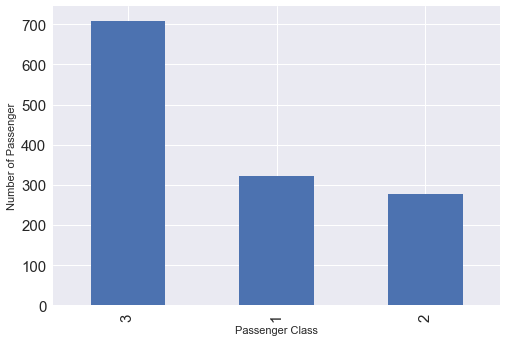

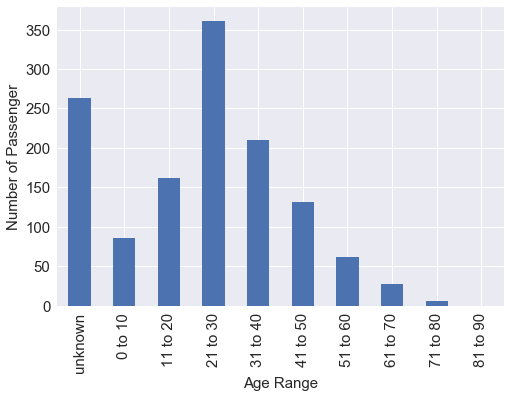

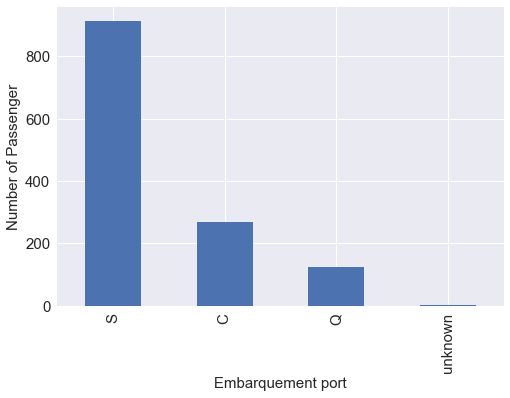

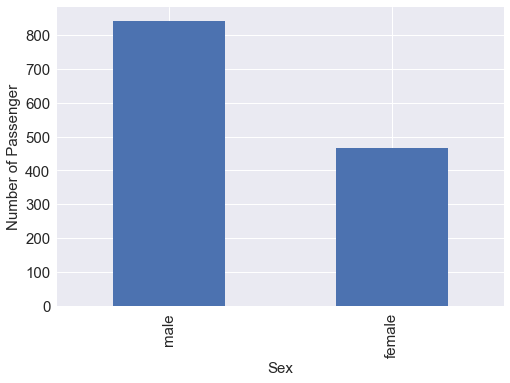

In [102]:
'''Plot histograms for the *travel class*, *embarkation port*,
*sex* and *age* attributes. For the latter one, use *discrete decade intervals*.'''

#ax=my_titanic.pclass.hist(normed=True)
#ax = my_titanic.pclass.hist(by=my_titanic.pclass)
ax = my_titanic.pclass.value_counts().plot.bar(fontsize=15)
#for i,x in enumerate (ax):
#    #print(type(x[0]))
#    print(x[0])
#    x[0].set_xlabel('Passenger Class {}'.format(i+1))
#    x[0].set_ylabel('Number of Passenger')
#plt.show()
ax.set_ylabel('Number of Passenger',fontsize=15)
ax.set_xlabel('Passenger Class',fontsize=15)
plt.show()

new_age=pd.cut(my_titanic.age, [-2,0,10,20,30,40,50,60,70,80,90]).value_counts(sort=False)
bx=new_age.plot.bar(fontsize=15)
bx.set_ylabel('Number of Passenger',fontsize=15)
bx.set_xlabel('Age Range',fontsize=15)
bx.set_xticklabels(['unknown','0 to 10','11 to 20','21 to 30', \
                    '31 to 40','41 to 50','51 to 60','61 to 70', \
                    '71 to 80','81 to 90','91 to 100'],fontsize=15)
#ax1.set_xticklabels=new_age
plt.show()

cx=my_titanic.embarked.value_counts().plot.bar(fontsize=15)
cx.set_ylabel('Number of Passenger',fontsize=15)
cx.set_xlabel('Embarquement port',fontsize=15)
#ax1.set_xticklabels([c[1:-1].replace(","," to") for c in new_age.cat.categories])
plt.show()

dx=my_titanic.sex.value_counts().plot.bar(fontsize=15)
dx.set_ylabel('Number of Passenger',fontsize=15)
dx.set_xlabel('Sex',fontsize=15)
plt.show()

### Question 2: 
Here we have chosen barplots representations. An unkown category was added for the age and the city of embarkment. 

Discussion: 
1)Half of the passengers were in the 3rd class. The second half was equally split between class 1 and 2 
2)Most of the passenger were under 30, and more than half is less than 40 years old. We make the assumption that the ages with decimals <0 are correct because people travelled with their babies. ased on the distribution of the population, passagers with age unknown are most likely young ones. 
3)Most of the passengers embarked from Southampton, the rest emarked from Cherbourg and Queenstown and 'unknown' ports
4)There was almost twice as much males than females on the titanic. 
	 
	


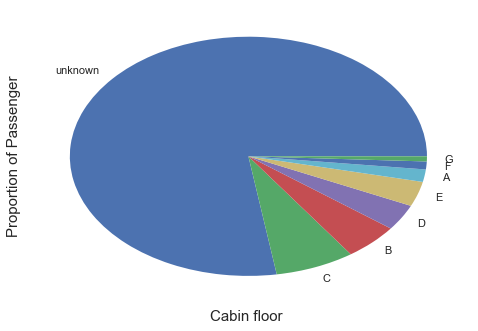

In [105]:
'''Calculate the proportion of passengers by *cabin floor*.'''
dx=my_titanic.cabin_floor.value_counts().plot.pie(fontsize=11)
dx.set_ylabel('Proportion of Passenger',fontsize=15)
dx.set_xlabel('Cabin floor ',fontsize=15)
plt.show()


### Question 3: 
Here we have assumed that the first letter of the Cabin field indicated the floor of the boat. Therefore a new column with the floor was added to table prior to Categorical values transformation. The cabin T and NaN are replaced by an unknown field. For F E57 types only the second letter is used as floor indicator.

We observe that most passengers were concentrated on floors B, C, D. For a important part of the population, the floor is unknown. 

        Death  Survival  Sum_pergroup
pclass                               
1        38.0      62.0           323
2        57.0      43.0           277
3        74.0      26.0           709
        Death  Survival  Sum_pergroup
pclass                               
1         123       200           323
2         158       119           277
3         528       181           709


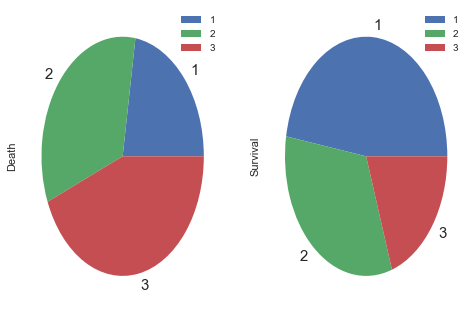

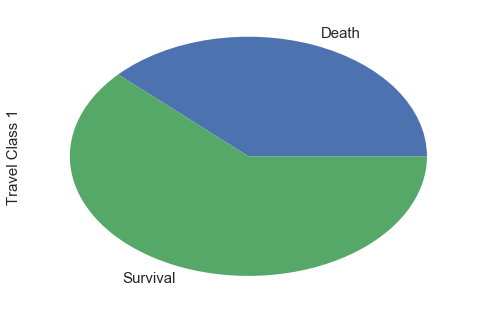

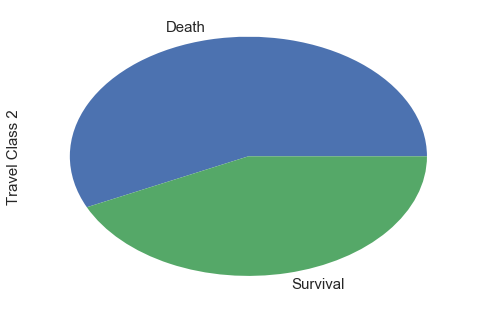

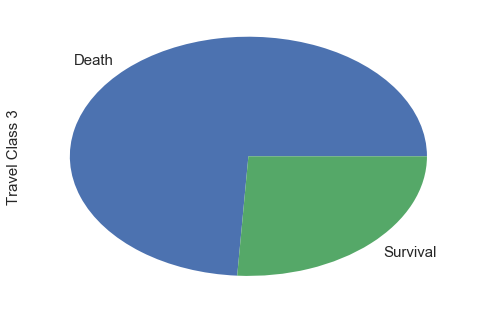

In [106]:
'''For each *travel class*, calculate the proportion of the passengers that survived. '''


#Group by Class
tmp=my_titanic.groupby(['pclass'])['survived'].value_counts()
tmp=tmp.unstack()
tmp.columns=['Death','Survival']
tmp['Sum_pergroup']=tmp.sum(axis=1)
tmp2=tmp.copy()
tmp['Death']=round(tmp.Death/tmp.Sum_pergroup*100)
tmp['Survival']=round(tmp.Survival/tmp.Sum_pergroup*100)
#tmp['Death','Survival'] =[tmp.Death/tmp.Sum_pergroup,tmp.Survival/tmp.Sum_pergroup]
print(tmp)
print(tmp2)

#Plot Version 2
forplot=tmp.iloc[:,0:2].plot.pie(subplots=True,fontsize=15)
#forplot.set_ylabel('Percent')
#forplot.set_xlabel('Travel Class')
plt.show()

#Plot Version 1
for i in range(3):
    forplot1=tmp.iloc[i,0:2].plot.pie(fontsize=15)
    forplot1.set_ylabel('Travel Class {}'.format(i+1),fontsize=15)
    plt.show()
    
    
    
    


### Question 4: 
Here the proportions of survivors are 62, 43, 26 percent for travel classes 1, 2, 3 respectively.

               Death  Survival  Sum_pergroup
pclass sex                                  
1      female    3.0      97.0           144
       male     66.0      34.0           179
2      female   11.0      89.0           106
       male     85.0      15.0           171
3      female   51.0      49.0           216
       male     85.0      15.0           493
               Death  Survival  Sum_pergroup
pclass sex                                  
1      female      5       139           144
       male      118        61           179
2      female     12        94           106
       male      146        25           171
3      female    110       106           216
       male      418        75           493


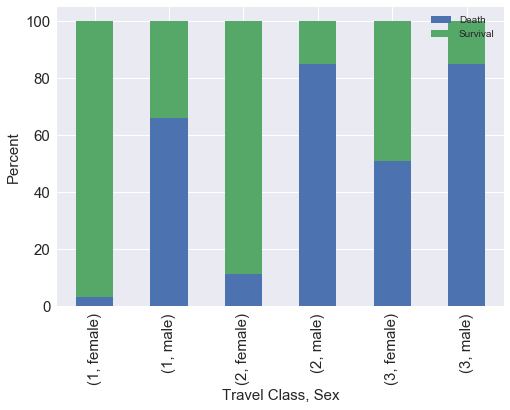

In [112]:
'''Calculate the proportion of the passengers that survived by *travel class* and *sex*.'''
tmp=my_titanic.groupby(['pclass','sex'])['survived'].value_counts()
tmp=tmp.unstack()
tmp.columns=['Death','Survival']
                #print(tmp.loc[1,'female']['Death'])
tmp['Sum_pergroup']=tmp.sum(axis=1)
tmp2=tmp.copy()
tmp['Death']=round(tmp.Death/tmp.Sum_pergroup*100)
tmp['Survival']=round(tmp.Survival/tmp.Sum_pergroup*100)
#tmp['Death','Survival'] =[tmp.Death/tmp.Sum_pergroup,tmp.Survival/tmp.Sum_pergroup]
print(tmp)
print(tmp2)


forplot=tmp[['Death','Survival']].plot.bar(stacked=True, fontsize=15)
forplot.set_ylabel('Percent',fontsize=15)
forplot.set_xlabel('Travel Class, Sex',fontsize=15)
plt.show()


### Question 5
The single histogram shows tht the highest survival rates are found amoung women of fisrt and second class. Among men survival was higher is 3rd class. 


In [113]:
'''Create 2 equally populated *age categories*'''
'''Equal Partition'''
my_titanic.age.fillna(int(-1), inplace=True) #this leaves some NaN!!
# Create a new column of ages with the rounded value and the unknown values
my_titanic['new_ages_Class']=0
my_titanic['new_ages_Class'][my_titanic.age>=0]=round(my_titanic.age[my_titanic.age>=1])
my_titanic['new_ages_Class'][my_titanic.age<0]=my_titanic.age[my_titanic.age<0]
tmp=my_titanic.groupby(['new_ages_Class'])['new_ages_Class'].value_counts()

'''Look for ideal partition by permuting ages until the partition is exact'''
#Total Passenger/ 2 =654.5 persons
bar=0 
while bar==0:
    shuffle_indices = np.random.permutation(len(tmp))
    tmp=tmp[shuffle_indices]
    for i,vali in enumerate(tmp.cumsum()):
        if vali==654 | 655:
            partition_ix=i
            print('true')
            bar=1

true


In [114]:
sum(tmp[0:partition_ix+1])

655

In [115]:
'''Partition according to ideal partition'''
my_titanic['age.partition']=0
left_partition=list(tmp[partition_ix+2:].index.labels[1])
right_partition=list(tmp[0:partition_ix+1].index.labels[1])
my_titanic['age.partition'][my_titanic['new_ages_Class'].isin(right_partition)]=1      


651

In [117]:
'''Calculate survival proportions by *age category*, *travel class* and *sex*. '''
tmp=my_titanic.groupby(['age.partition','pclass','sex'])['survived'].value_counts()
tmp=tmp.unstack()
tmp.columns=['Death','Survival']
tmp['Sum_pergroup']=tmp.sum(axis=1)
tmp['Death']=round(tmp.Death/tmp.Sum_pergroup*100)
tmp['Survival']=round(tmp.Survival/tmp.Sum_pergroup*100)
tmp=tmp.iloc[:,0:2]
print(tmp)
tmp.index.is_unique #Unique (Multi Index )


                             Death  Survival
age.partition pclass sex                    
0             1      female    4.0      96.0
                     male     62.0      38.0
              2      female    9.0      91.0
                     male     83.0      17.0
              3      female   56.0      44.0
                     male     85.0      15.0
1             1      female    3.0      97.0
                     male     71.0      29.0
              2      female   13.0      87.0
                     male     87.0      13.0
              3      female   44.0      56.0
                     male     84.0      16.0


True

### Question 6 
To create two populations equally populated the strategy adopted was the following. (1) Create age classes defined by integer values (2) Shuffle the order of these 100 subclasses to get the age partition of 50-50. 

We can observe than between the two "randomized" partitions the death and survival rates are close.

In [ ]:

print(html.unescape('&pound;682m'))
